### Plan
1- Have a simple dataset (sinusoid only), with hole in middle

2- Define encoder (x -> z) and decoder (z -> x) using architectures from NP implementation (Yann Dubs)

3- Define the losses of the HackMD

4- Instead of Bx, By, use a fixed small set (of 1 or more points)

5- Visualizations: Different f_z(x) before and while and after training

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, random_split
#from networks import Model
#from dropout import *

from data import generate_data, linear_quadratic
#from train import train_main_model, train_deup
#from utils import inv_sigmoid, evaluate_and_plot, eval_error

import itertools

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def running_mean(x, N=100):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

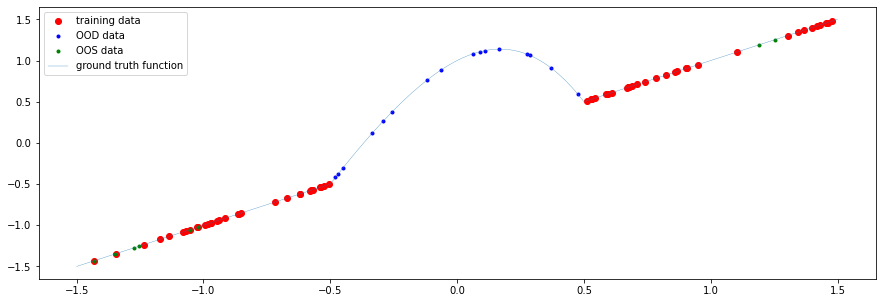

In [58]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(64, 16, 32, seed=7, plot=True, device=device, shuffle=True, one_sine=False, oracle=linear_quadratic)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, width=128, n_hidden=2, output_dim=1):
        super().__init__()
        self.x_layer = nn.Linear(input_dim, width)
        self.hiddens = nn.ModuleList([nn.Linear(width, width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(width, output_dim)
    
    def forward(self, x):
        out = F.relu(self.x_layer(x))
        for i, l in enumerate(self.hiddens):
            out = F.relu(l(out))
        return self.output_layer(out)
    
class Aggregator(nn.Module):
    def forward(self, r):
        # r should be a batch of representation of size B x d
        return r.mean(0).unsqueeze(0)
    
def loss(dataset1, dataset2, z_sample, K=2):
    x_1, y_1 = dataset1[:]
    x_2, y_2 = dataset2[:]
    dataset_cat = torch.cat((x_1, y_1), 1)
    dataset_r = encoder(dataset_cat)
    dataset_r = aggregator(dataset_r)
    mu = mu_net(dataset_r)
    sigma = F.softplus(torch.sigma_net(dataset_r))
    z = mu + sigma * torch.randn(K, mu.shape[1])
    
    decoder_inputs = torch.cat((x_2.repeat(K, 1, 1), z.repeat(x_2.shape[0], 1, 1).transpose(0, 1)), -1)  # K x B x ( 1 + z_dim)
    predictions = decoder(decoder_inputs)  # K x B x 1
    
    variance = predictions.var(0)  # B x 1
    residual_0 = (predictions[0] - y_2) ** 2
    loss_1 = nn.MSELoss()(residual_0, variance)
    
    predictions_mat = predictions.squeeze(-1)  # K x B
    predictions_mat -= predictions_mat.mean(0)
    covariance = predictions_mat.transpose(0, 1)@predictions_mat  # B x B
    co_residual_01 = torch.outer((predictions[0] - y_2).squeeze(-1), (predictions[1] - y_2).squeeze(-1))
    loss_2 = nn.MSELoss()(co_residual_01, covariance)
    
    main_decoder_inputs = torch.cat((x_1.repeat(K, 1, 1), z.repeat(x_1.shape[0], 1, 1).transpose(0, 1)), -1)  # K x B x ( 1 + z_dim)
    main_predictions = decoder(main_decoder_inputs)  # K x B x 1
    residuals = (main_predictions - y_1) ** 2 # K x B x 1
    loss_3 = residuals.mean()
    
    mu_decoder_inputs = torch.cat((x_1, mu), -1)
    mu_predictions = decoder(mu_decoder_inputs)  # B x 1
    loss_4 = nn.MSELoss()(mu_predictions, y_1)

    

In [132]:
z_dim = 16
LR = 1e-4
K = 5

beta, gamma, delta = 1., 1., 1.
encoder = MLP(input_dim=2, output_dim=z_dim).to(device=device)
aggregator = Aggregator().to(device=device)
decoder = MLP(input_dim=1 + z_dim, output_dim=1, n_hidden=4, width=512).to(device=device)
mu_net = MLP(input_dim=z_dim, n_hidden=1, output_dim=z_dim).to(device=device)
sigma_net = MLP(input_dim=z_dim, n_hidden=1, output_dim=z_dim).to(device=device)
optimizer = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters(), mu_net.parameters(), sigma_net.parameters()), lr=LR)

In [133]:
full_X = torch.cat((x, ood_x[:1], oos_x))
full_Y= torch.cat((y, ood_y[:1], oos_y))
B_X = ood_x[1:]
B_Y = ood_y[1:]
full_data = TensorDataset(full_X, full_Y)
acquired_data = TensorDataset(B_X, B_Y)

losses = []
losses_1 = []
losses_2 = []
losses_3 = []
losses_4 = []
for epoch in range(1000):
    if epoch % 100 == 0:
        print(epoch)
    optimizer.zero_grad()
    train, test = random_split(full_data, [int(0.75 * len(full_data)), len(full_data) - int(0.75 * len(full_data))])
    
    x_1, y_1 = train[:]
    x_2, y_2 = random_split(TensorDataset(B_X, B_Y), [1, len(B_X) -1])[0][:]
    dataset_cat = torch.cat((x_1, y_1), 1)
    dataset_r = encoder(dataset_cat)
    dataset_r = aggregator(dataset_r)
    mu = mu_net(dataset_r)
    sigma = F.softplus(sigma_net(dataset_r))
    z = mu + sigma * torch.randn(K, mu.shape[1]).to(device=device)
    
    decoder_inputs = torch.cat((x_2.repeat(K, 1, 1), z.repeat(x_2.shape[0], 1, 1).transpose(0, 1)), -1)  # K x B x ( 1 + z_dim)
    predictions = decoder(decoder_inputs)  # K x B x 1
    
    variance = predictions.var(0)  # B x 1
    residual_0 = (predictions[0] - y_2) ** 2
    loss_1 = nn.MSELoss()(residual_0, variance)
    
    predictions_mat = predictions.squeeze(-1)  # K x B
    predictions_mat = predictions_mat - predictions_mat.mean(0)
    covariance = predictions_mat.transpose(0, 1)@predictions_mat  # B x B
    co_residual_01 = torch.outer((predictions[0] - y_2).squeeze(-1), (predictions[1] - y_2).squeeze(-1))
    loss_2 = nn.MSELoss()(co_residual_01, covariance)
    
    main_decoder_inputs = torch.cat((x_1.repeat(K, 1, 1), z.repeat(x_1.shape[0], 1, 1).transpose(0, 1)), -1)  # K x B x ( 1 + z_dim)
    main_predictions = decoder(main_decoder_inputs)  # K x B x 1
    residuals = (main_predictions - y_1) ** 2 # K x B x 1
    loss_3 = residuals.mean()
    
    mu_decoder_inputs = torch.cat((x_1, mu.repeat(x_1.shape[0], 1)), -1)
    mu_predictions = decoder(mu_decoder_inputs)  # B x 1
    loss_4 = nn.MSELoss()(mu_predictions, y_1)
    
    
    loss = loss_1 + beta * loss_2 + gamma * loss_3 + delta * loss_4
    losses.append(loss.item())
    losses_1.append(loss_1.item())
    losses_2.append(loss_2.item())
    losses_3.append(loss_3.item())
    losses_4.append(loss_4.item())
    loss.backward()
    
    optimizer.step()

0
100
200
300
400
500
600
700
800
900


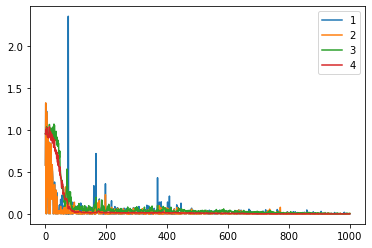

In [134]:
# plt.plot(losses)
plt.plot(losses_1, label='1')
plt.plot(losses_2, label='2')
plt.plot(losses_3, label='3')
plt.plot(losses_4, label='4')
plt.legend()
plt.show()

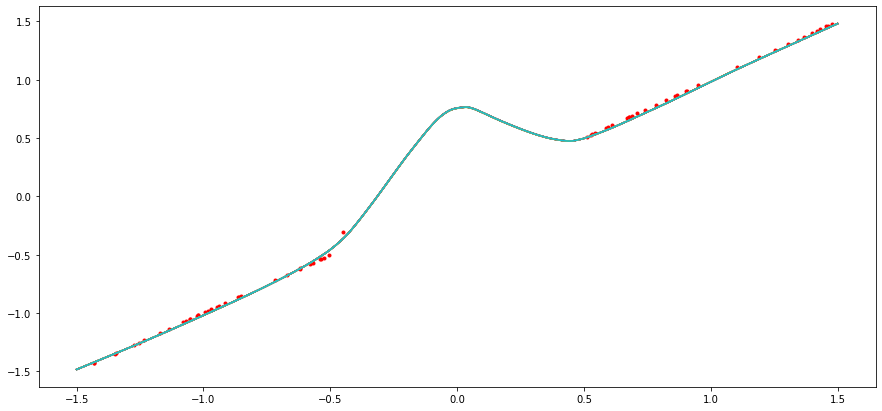

In [135]:
plt.figure(figsize=(15, 7))
plt.plot(full_X.cpu(), full_Y.cpu(), 'r.')
# plt.plot(train[:][0].cpu(), train[:][1].cpu(), 'cx')
for _ in range(20):
    train, test = random_split(full_data, [int(0.75 * len(full_data)), len(full_data) - int(0.75 * len(full_data))])
    dataset_cat = torch.cat((train[:][0], train[:][1]), 1)
    dataset_r = encoder(dataset_cat)
    dataset_r = aggregator(dataset_r)
    mu = mu_net(dataset_r)
    sigma = F.softplus(sigma_net(dataset_r))
    z = mu + sigma * torch.randn(mu.shape[1]).to(device=device)
    mu_decoder_inputs = torch.cat((x_test, mu.repeat(x_test.shape[0], 1)), -1)
    mu_predictions = decoder(mu_decoder_inputs)
    plt.plot(x_test.cpu(), mu_predictions.detach().cpu())